# Validation of the Mixing Matrix with spatial variability

In [37]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from fgbuster.observation_helpers import get_instrument, standardize_instrument, get_observation
from micmac import *

In [38]:
# Choose and get instrument from public database
instr_name = 'SO_SAT'    # LiteBIRD  # SO_SAT
instr_ = get_instrument(instr_name)
instrument = standardize_instrument(instr_)

In [39]:
# General parameters (in a Gibbs sampling run coming from the parameter file)
NSIDE = 64
ncomp = 3
n_fgs_comp = 2
pos_special_freqs = np.array([0, -1])

### Spv configuration

In [40]:
# Num betas
n_betas = (ncomp-1)*(len(instrument.frequency)-ncomp+1)

In [41]:
# Read the spv configuration and print the spv tree
# yaml_file_path = 'params_spv_SAT.yaml'   # ''  # 'params_spv_SAT.yaml'  # 'params_spv_LB.yaml'
yaml_file_path = 'params_spv_SAT_nside8.yaml'   # ''  # 'params_spv_SAT.yaml'  # 'params_spv_LB.yaml'
# yaml_file_path = 'params_spv_SAT_nside16.yaml'   # ''  # 'params_spv_SAT.yaml'  # 'params_spv_LB.yaml'
root_tree = tree_spv_config(yaml_file_path, n_betas, n_fgs_comp, print_tree=True)

<_io.TextIOWrapper name='params_spv_SAT_nside8.yaml' mode='r' encoding='UTF-8'>
count_b: 8
n_betas:  8

>>> Tree of spv config as passed by the User:
root
  nside_spv
    default: [16]
    f1
      default: None
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
    f2
      default: None
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None

>>> Tree of spv config after filling the missing values:
root
  nside_spv
    default: [16]
    f1
      default: [16]
      b0
        default: [16]
      b1
        default: [16]
      b2
        default: [16]
      b3
        default: [16]
    f2
      default: [16]
      b0
        default: [16]
      b1
        default: [16]
      b2
        default: [16]
      b3
        default: [16]


In [42]:
# Get list of the nodes betas
nodes_b = get_nodes_b(root_tree)
print("List of all the betas (first all the ones for component 1 then all the ones for compoents 2):\n", nodes_b)

List of all the betas (first all the ones for component 1 then all the ones for compoents 2):
 [Node('/root/nside_spv/f1/b0'), Node('/root/nside_spv/f1/b1'), Node('/root/nside_spv/f1/b2'), Node('/root/nside_spv/f1/b3'), Node('/root/nside_spv/f2/b0'), Node('/root/nside_spv/f2/b1'), Node('/root/nside_spv/f2/b2'), Node('/root/nside_spv/f2/b3')]


### Initialization Mixing Matrix

In [43]:
initB = InitMixingMatrix(freqs=instrument.frequency, ncomp=ncomp, pos_special_freqs=pos_special_freqs, spv_nodes_b=nodes_b)
init_params = initB.init_params()
print("N params:", init_params.shape)
print("Params initial values (given in the order: all params for b1, all params for b2, ...):\n", init_params)


N params: (24576,)
Params initial values (given in the order: all params for b1, all params for b2, ...):
 [0.33858815 0.33858815 0.33858815 ... 0.44076761 0.44076761 0.44076761]


### Mixing Matrix

Test preliminary functions

In [44]:
print(get_len_params(spv_nodes_b=nodes_b))

24576


Test Mixing Matrix

In [45]:
B = MixingMatrix(instrument.frequency, ncomp, nodes_b, NSIDE, init_params, pos_special_freqs)

In [46]:
params = B.params

In [47]:
%%time
params_long = B.get_params_long(jax_use=False)
print(params_long.shape)
print(params_long)

(4, 2, 49152)
[[[0.33858815 0.33858815 0.33858815 ... 0.33858815 0.33858815 0.33858815]
  [0.00979233 0.00979233 0.00979233 ... 0.00979233 0.00979233 0.00979233]]

 [[0.02963068 0.02963068 0.02963068 ... 0.02963068 0.02963068 0.02963068]
  [0.05147511 0.05147511 0.05147511 ... 0.05147511 0.05147511 0.05147511]]

 [[0.00998213 0.00998213 0.00998213 ... 0.00998213 0.00998213 0.00998213]
  [0.12913911 0.12913911 0.12913911 ... 0.12913911 0.12913911 0.12913911]]

 [[0.00328725 0.00328725 0.00328725 ... 0.00328725 0.00328725 0.00328725]
  [0.44076761 0.44076761 0.44076761 ... 0.44076761 0.44076761 0.44076761]]]
CPU times: user 2.71 s, sys: 139 ms, total: 2.84 s
Wall time: 2.48 s


In [48]:
%%time
params_long = B.get_params_long(jax_use=True)
print(params_long.shape)
print(params_long)

(4, 2, 49152)
[[[0.33858815 0.33858815 0.33858815 ... 0.33858815 0.33858815 0.33858815]
  [0.00979233 0.00979233 0.00979233 ... 0.00979233 0.00979233 0.00979233]]

 [[0.02963068 0.02963068 0.02963068 ... 0.02963068 0.02963068 0.02963068]
  [0.05147511 0.05147511 0.05147511 ... 0.05147511 0.05147511 0.05147511]]

 [[0.00998213 0.00998213 0.00998213 ... 0.00998213 0.00998213 0.00998213]
  [0.12913911 0.12913911 0.12913911 ... 0.12913911 0.12913911 0.12913911]]

 [[0.00328725 0.00328725 0.00328725 ... 0.00328725 0.00328725 0.00328725]
  [0.44076761 0.44076761 0.44076761 ... 0.44076761 0.44076761 0.44076761]]]
CPU times: user 4.51 s, sys: 445 ms, total: 4.95 s
Wall time: 2.75 s


In [93]:
def get_params_long_test(self, jax_use=False):
    n_unknown_freqs = self.n_frequencies-self.n_components+1
    n_comp_fgs = self.n_components-1

    ## Creating all the templates
    def create_all_templates_indexed_freq(idx_freq):
        def create_all_templates_indexed_comp(idx_comp):
            template_idx_comp = create_one_template_from_bdefaultvalue(jnp.expand_dims(self.values_b[idx_freq,idx_comp],axis=0), 
                                                            self.nside,
                                                            all_nsides=None, 
                                                            spv_templates=None, 
                                                            use_jax=True, 
                                                            print_bool=False)
            return template_idx_comp + self.sum_size_patches_indexed_freq_comp[idx_freq,idx_comp]
        template_idx_freq_comp = jax.vmap(create_all_templates_indexed_comp)(jnp.arange(n_comp_fgs))
        return template_idx_freq_comp

    ## Maping over the functions to create the templates
    # templates_to_fill = jax.vmap(create_all_templates_indexed_freq)(jnp.arange(n_unknown_freqs))
    templates_to_fill = jnp.array(jax.vmap(create_all_templates_indexed_freq)(jnp.arange(n_unknown_freqs)), dtype=int)

    
    ## Filling the templates with parameters values
    def fill_params_long_b(carry, ind_params):
        return jnp.where(templates_to_fill == ind_params, jnp.array(self.params)[ind_params], 0) + carry, None
    return jax.lax.scan(fill_params_long_b, jnp.zeros((n_unknown_freqs, n_comp_fgs, self.n_pix)), jnp.arange(self.len_params))[0]
    # return self.pure_call_ud_get_params_long_python(self.params)

def get_params_long_test_2(self, jax_use=False):
    n_unknown_freqs = self.n_frequencies-self.n_components+1
    n_comp_fgs = self.n_components-1

    ## Creating all the templates
    def create_all_templates_indexed_freq(idx_freq):
        def create_all_templates_indexed_comp(idx_comp):
            template_idx_comp = create_one_template_from_bdefaultvalue(jnp.expand_dims(self.values_b[idx_freq,idx_comp],axis=0), 
                                                            self.nside,
                                                            all_nsides=None, 
                                                            spv_templates=None, 
                                                            use_jax=True, 
                                                            print_bool=False)
            return template_idx_comp + self.sum_size_patches_indexed_freq_comp[idx_freq,idx_comp]
        template_idx_freq_comp = jax.vmap(create_all_templates_indexed_comp)(jnp.arange(n_comp_fgs))
        return template_idx_freq_comp

    ## Maping over the functions to create the templates
    templates_to_fill = jnp.array(jax.vmap(create_all_templates_indexed_freq)(jnp.arange(n_unknown_freqs)), dtype=int)

    return self.params.at[templates_to_fill].get()
    # ## Filling the templates with parameters values
    # def fill_params_long_b(carry, ind_params):
    #     return jnp.where(templates_to_fill == ind_params, jnp.array(self.params)[ind_params], 0) + carry, None
    # return jax.lax.scan(fill_params_long_b, jnp.zeros((n_unknown_freqs, n_comp_fgs, self.n_pix)), jnp.arange(self.len_params))[0]
    # return self.pure_call_ud_get_params_long_python(self.params)


In [49]:
B_fgs = B.get_B_fgs()

In [50]:
B_fgs[:,:,0]

array([[1.        , 0.        ],
       [0.33858815, 0.00979233],
       [0.02963068, 0.05147511],
       [0.00998213, 0.12913911],
       [0.00328725, 0.44076761],
       [0.        , 1.        ]])

In [51]:
B.get_B_cmb().shape

(6, 1, 49152)

In [52]:
B.get_B()[:,:,0]

array([[1.        , 1.        , 0.        ],
       [1.        , 0.33858815, 0.00979233],
       [1.        , 0.02963068, 0.05147511],
       [1.        , 0.00998213, 0.12913911],
       [1.        , 0.00328725, 0.44076761],
       [1.        , 0.        , 1.        ]])

In [53]:
new_params = np.copy(B.params)
new_params[0] += 10
new_params[1] += 20
new_params[50] += 20
new_params

array([10.33858815, 20.33858815,  0.33858815, ...,  0.44076761,
        0.44076761,  0.44076761])

In [54]:
B.update_params(new_params)
print(B.get_params_long(jax_use=True))


[[[1.03385881e+01 2.03385881e+01 3.38588146e-01 ... 3.38588146e-01
   3.38588146e-01 3.38588146e-01]
  [9.79233500e-03 9.79233500e-03 9.79233500e-03 ... 9.79233500e-03
   9.79233500e-03 9.79233500e-03]]

 [[2.96306809e-02 2.96306809e-02 2.96306809e-02 ... 2.96306809e-02
   2.96306809e-02 2.96306809e-02]
  [5.14751134e-02 5.14751134e-02 5.14751134e-02 ... 5.14751134e-02
   5.14751134e-02 5.14751134e-02]]

 [[9.98212728e-03 9.98212728e-03 9.98212728e-03 ... 9.98212728e-03
   9.98212728e-03 9.98212728e-03]
  [1.29139113e-01 1.29139113e-01 1.29139113e-01 ... 1.29139113e-01
   1.29139113e-01 1.29139113e-01]]

 [[3.28725430e-03 3.28725430e-03 3.28725430e-03 ... 3.28725430e-03
   3.28725430e-03 3.28725430e-03]
  [4.40767614e-01 4.40767614e-01 4.40767614e-01 ... 4.40767614e-01
   4.40767614e-01 4.40767614e-01]]]


In [55]:
fake_params = np.arange(B.len_params)#.reshape(())
B.update_params(fake_params)

params_long = B.get_params_long(jax_use=True)

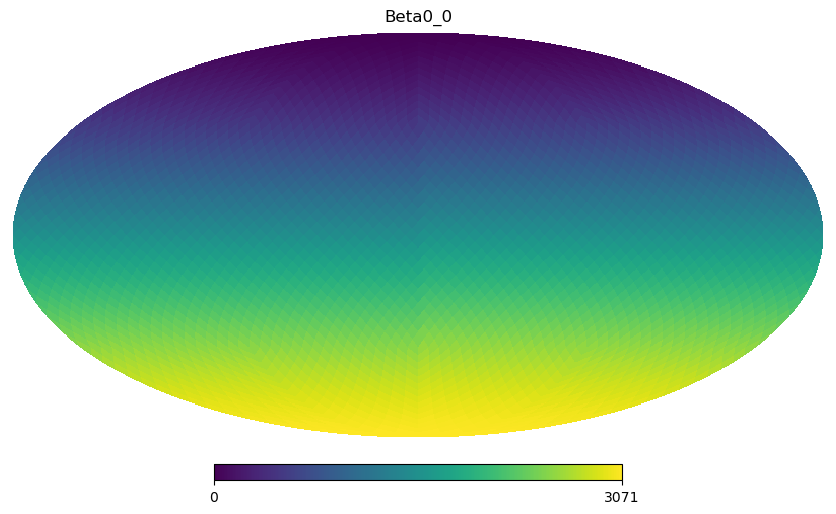

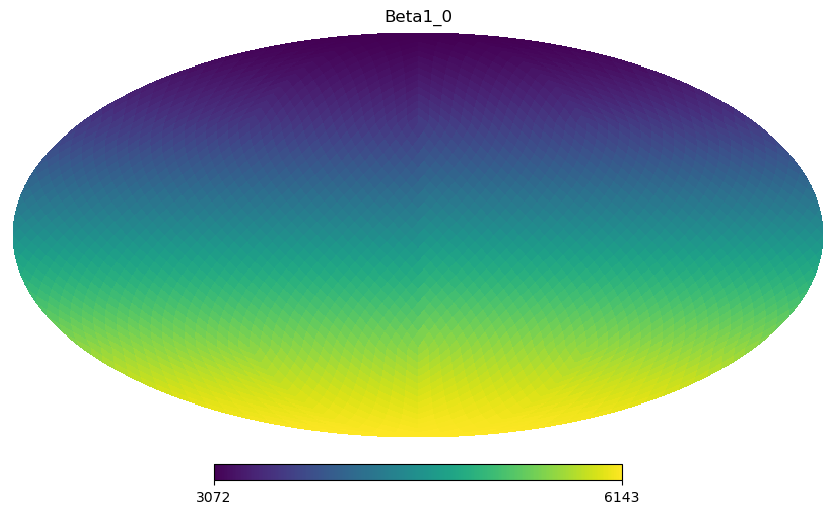

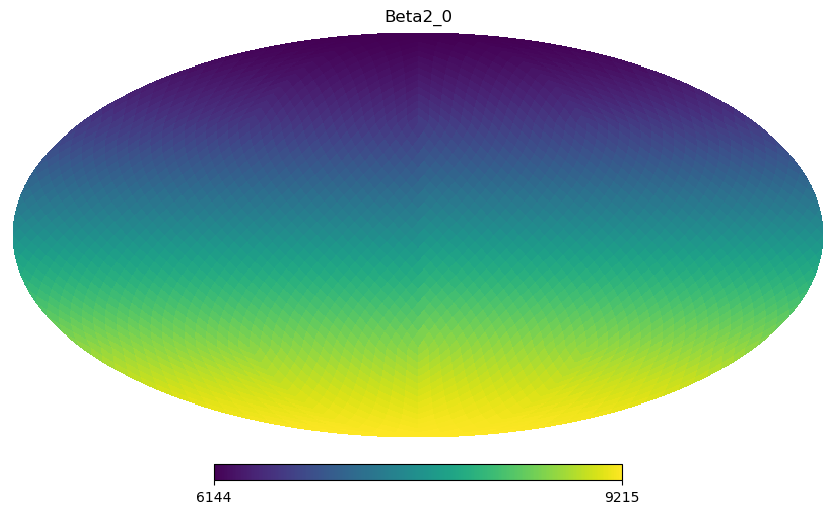

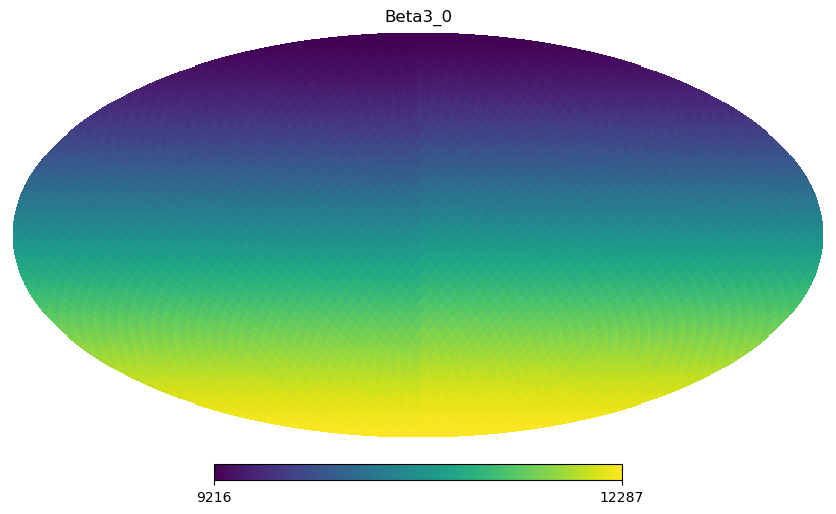

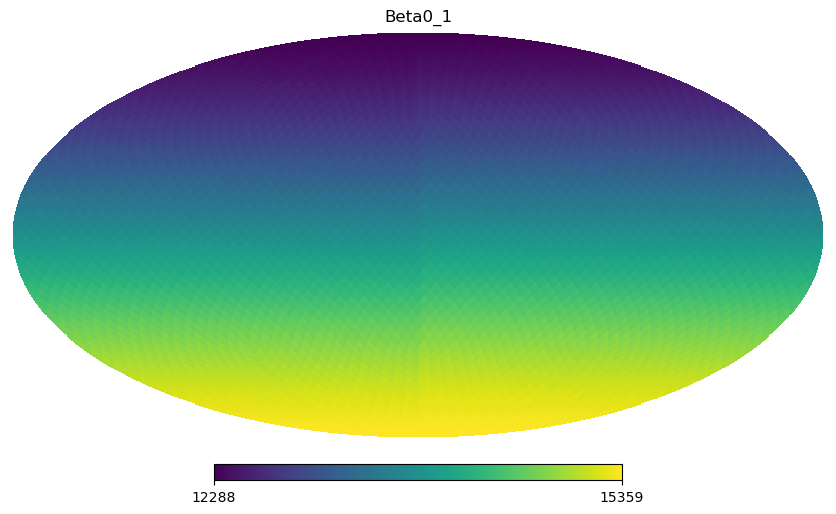

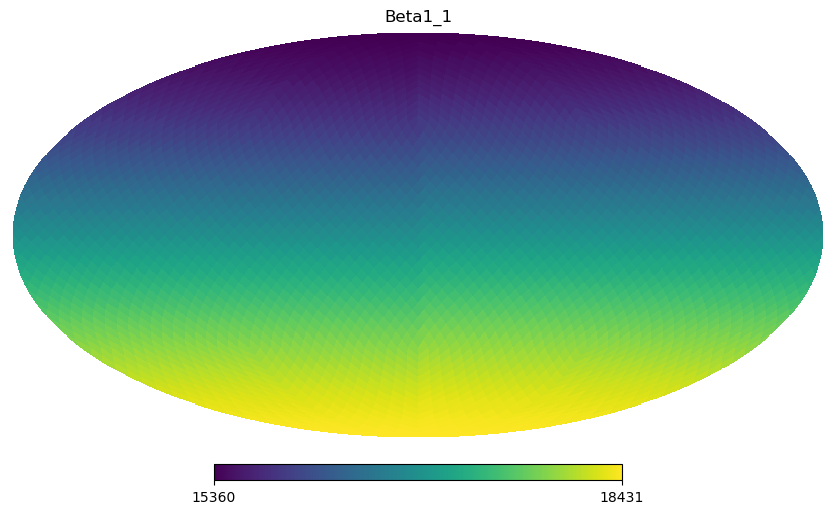

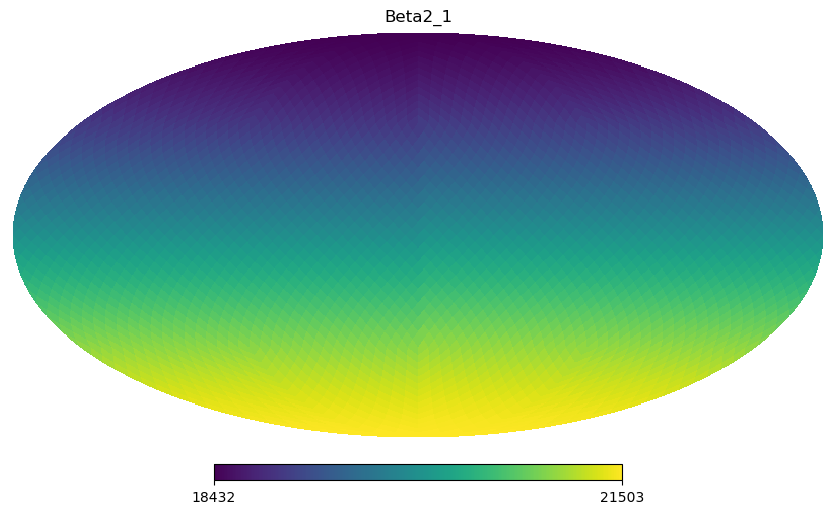

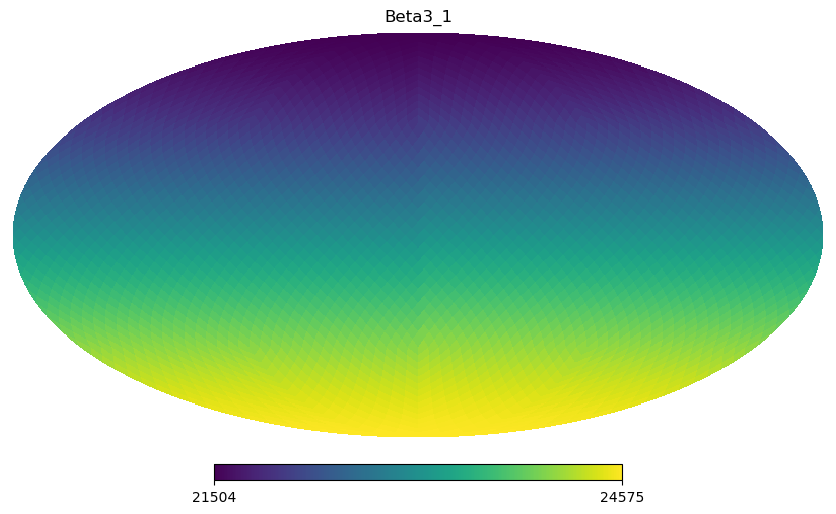

In [56]:
params_long.shape
for j in range(2):
    for i in range(4):
        hp.mollview(params_long[i,j], title='Beta'+str(i)+'_'+str(j))

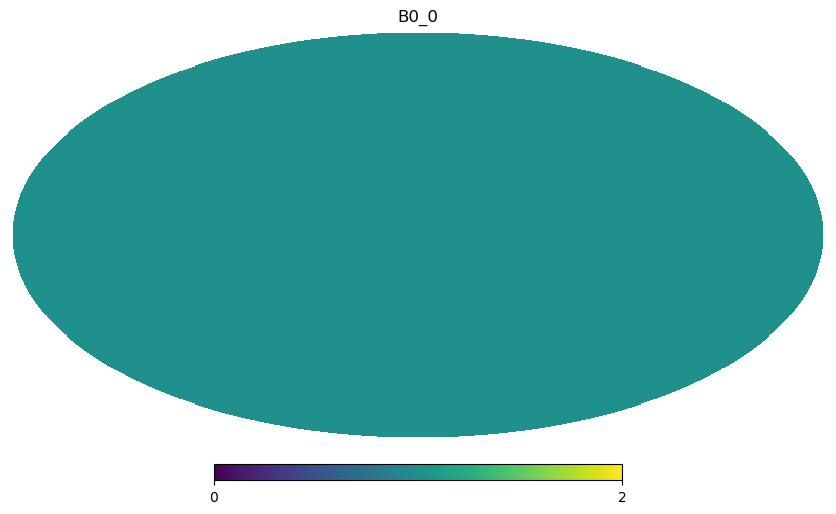

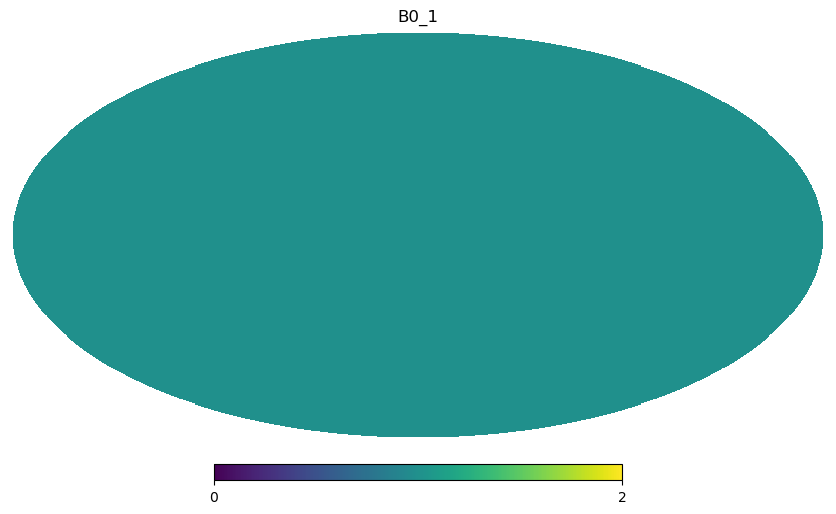

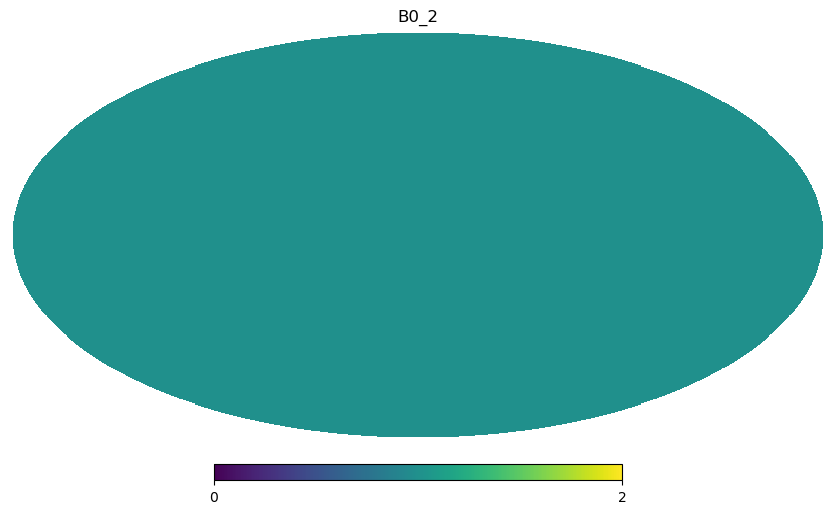

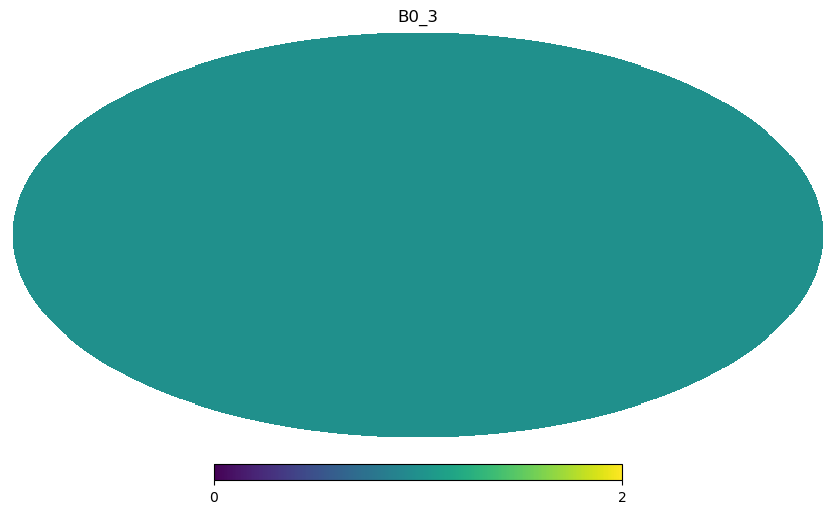

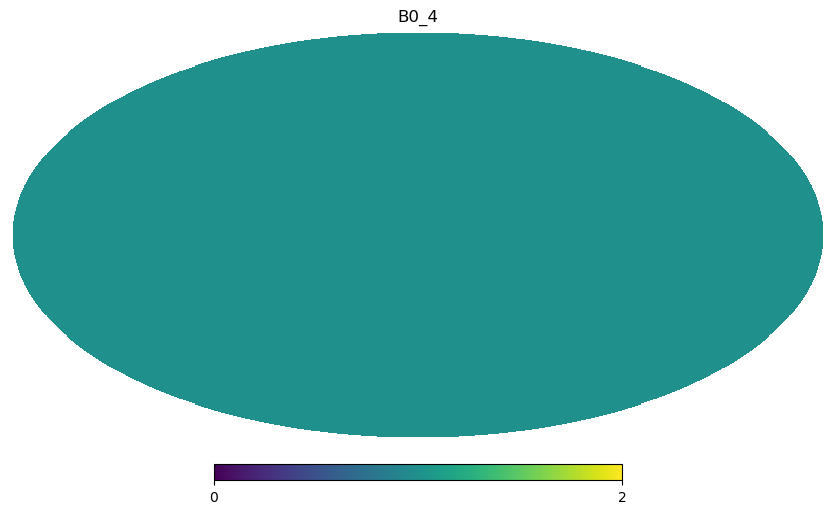

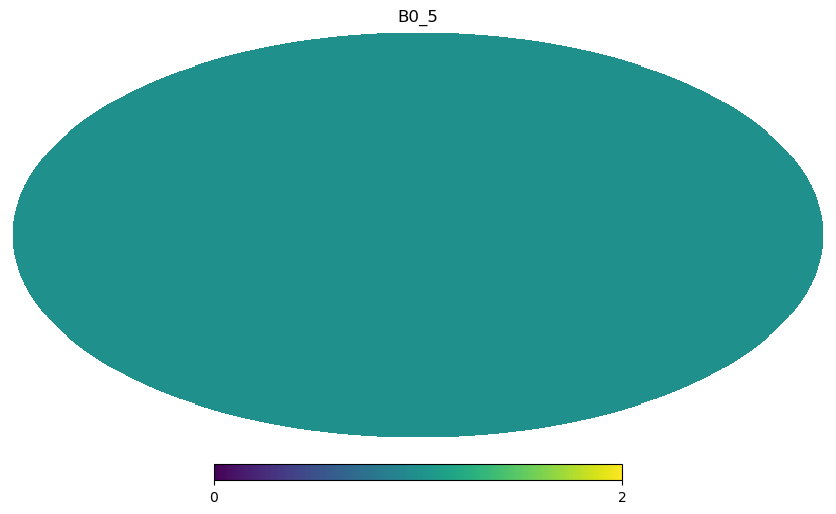

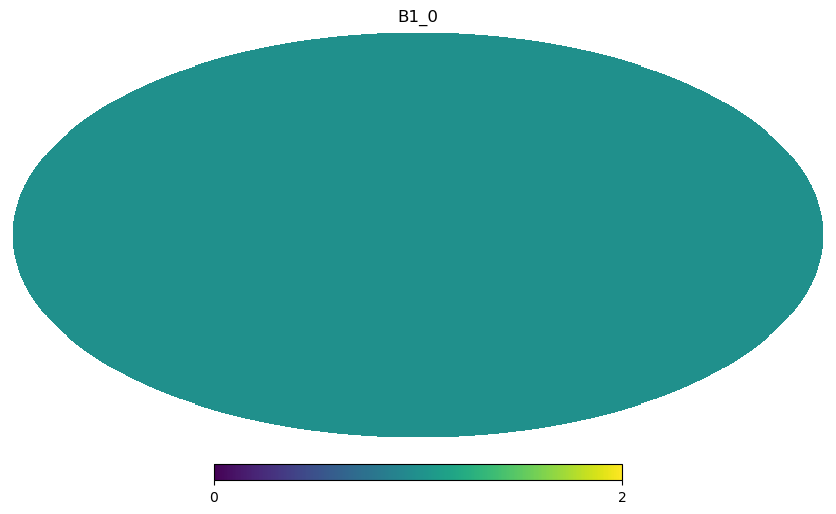

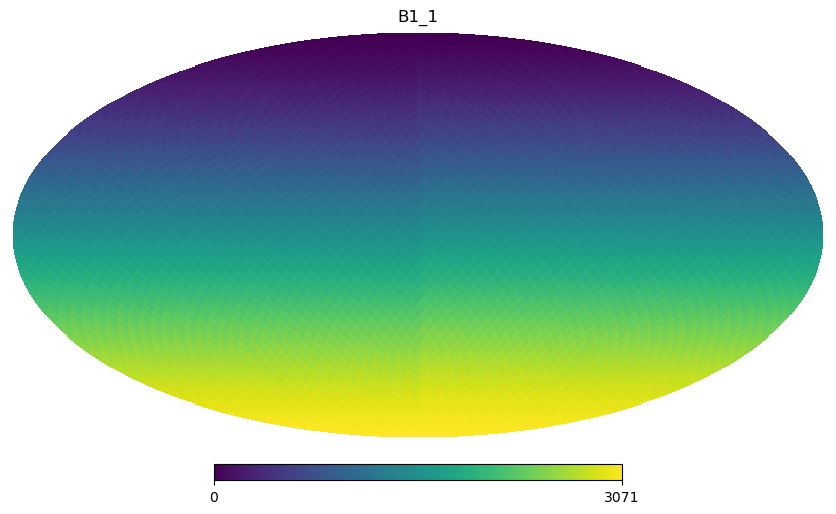

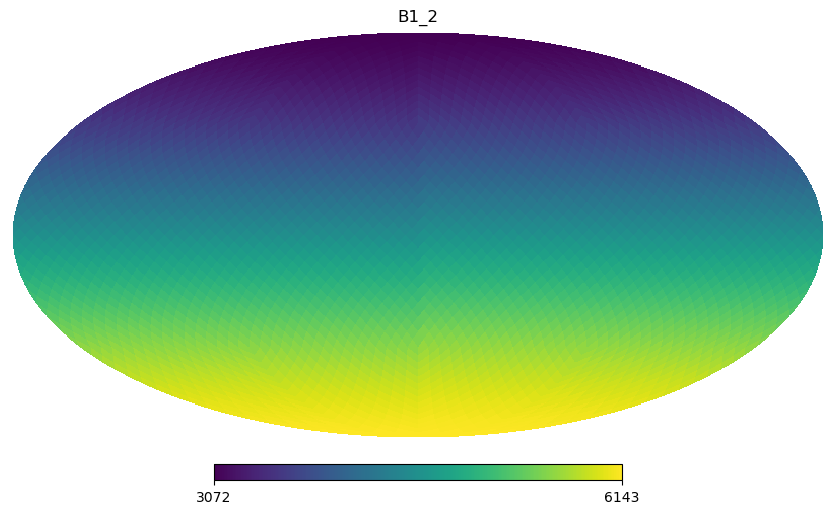

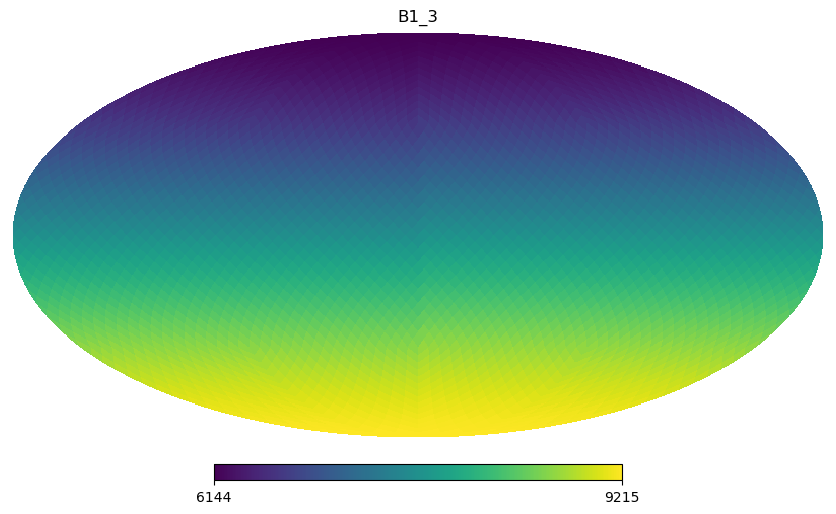

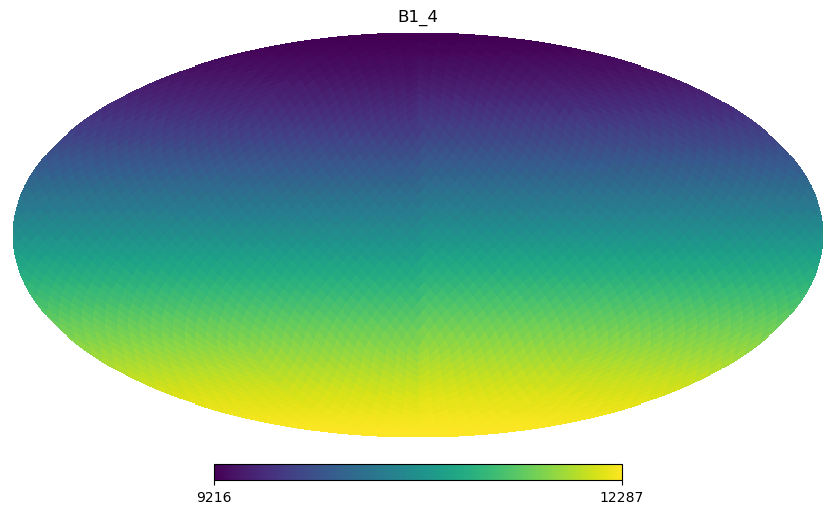

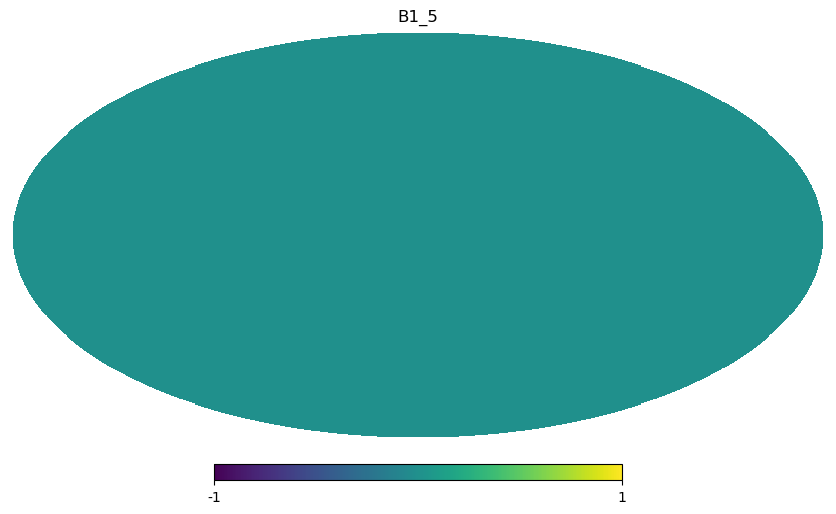

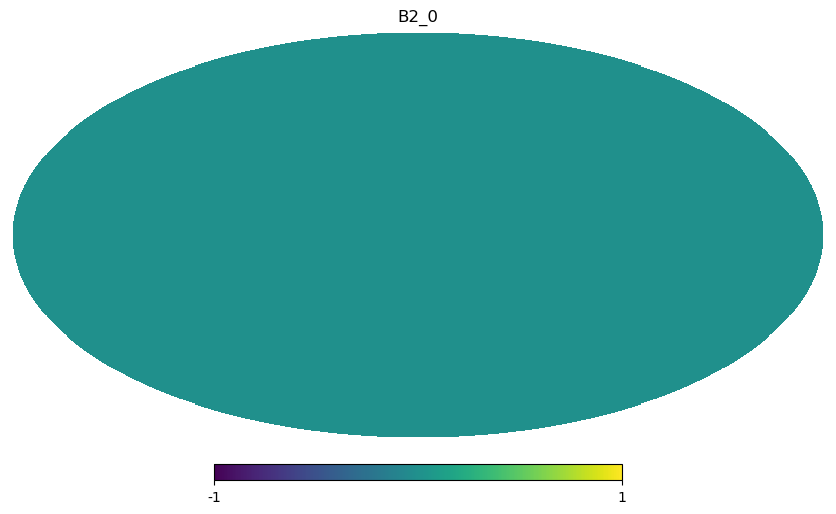

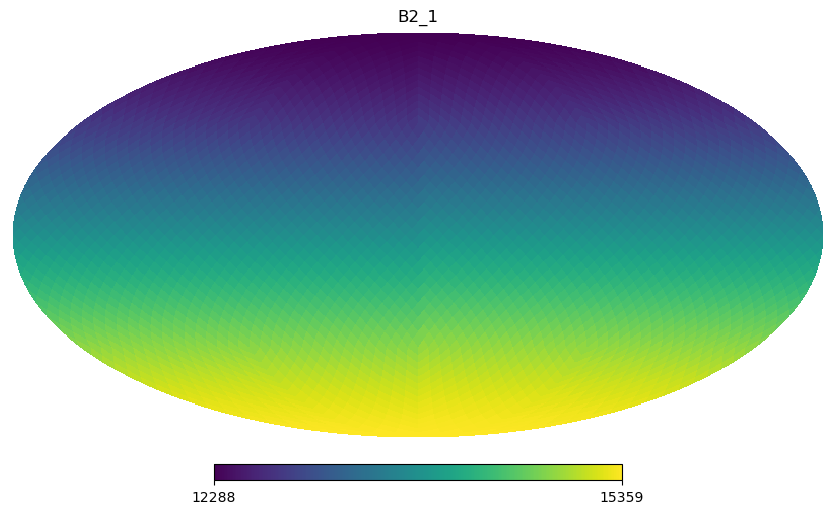

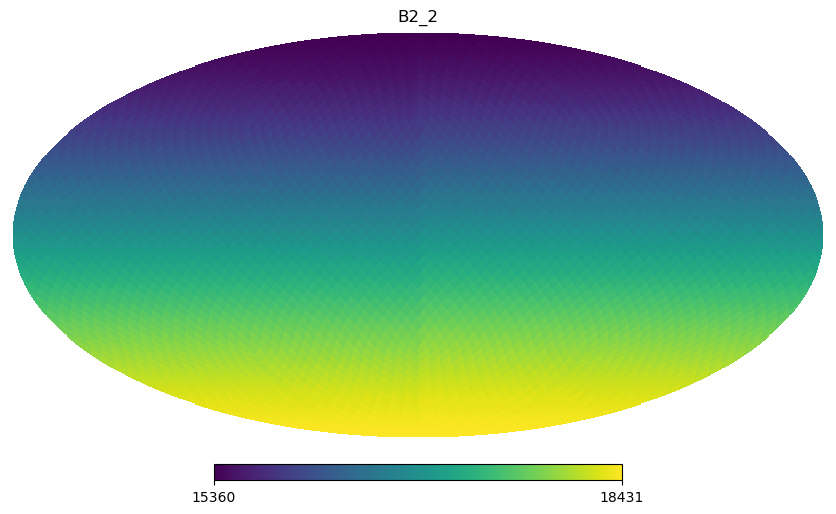

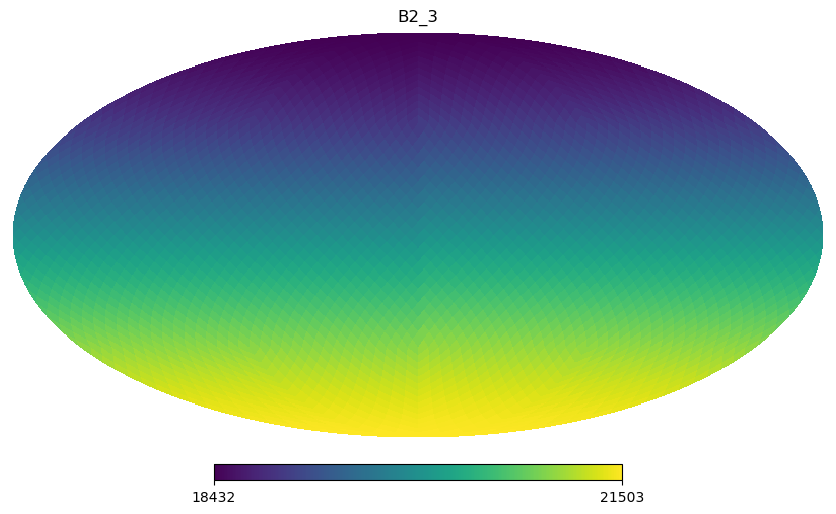

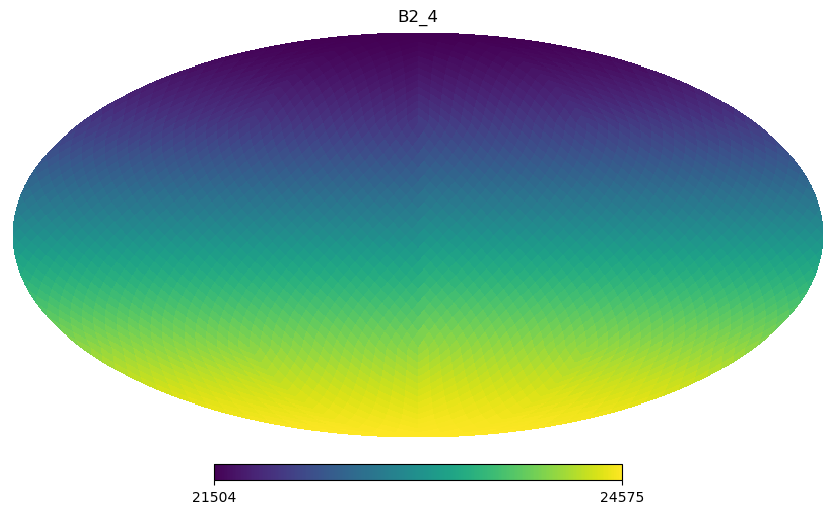

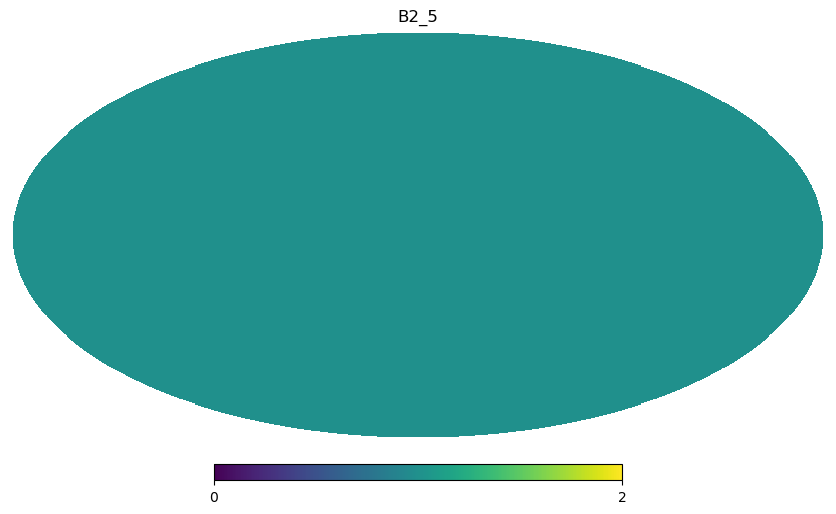

In [57]:
test_mixing_matrix = B.get_B(jax_use=True)

for i in range(3):
    for j in range(6):
        hp.mollview(test_mixing_matrix[j,i], title='B'+str(i)+'_'+str(j))

In [58]:
test_freq_inv_noise = get_noise_covar_extended(1/np.sqrt(np.ones(B.n_frequencies)+1), B.nside)

BtinN = get_BtinvN(test_freq_inv_noise, test_mixing_matrix)
inv_BtinvNB = get_inv_BtinvNB(test_freq_inv_noise, test_mixing_matrix)

In [59]:
BtinvN_ = get_BtinvN(test_freq_inv_noise, test_mixing_matrix, True)
inv_BtinvNB_2 = np.einsum("chp,hfp->cfp", BtinvN_, test_mixing_matrix)

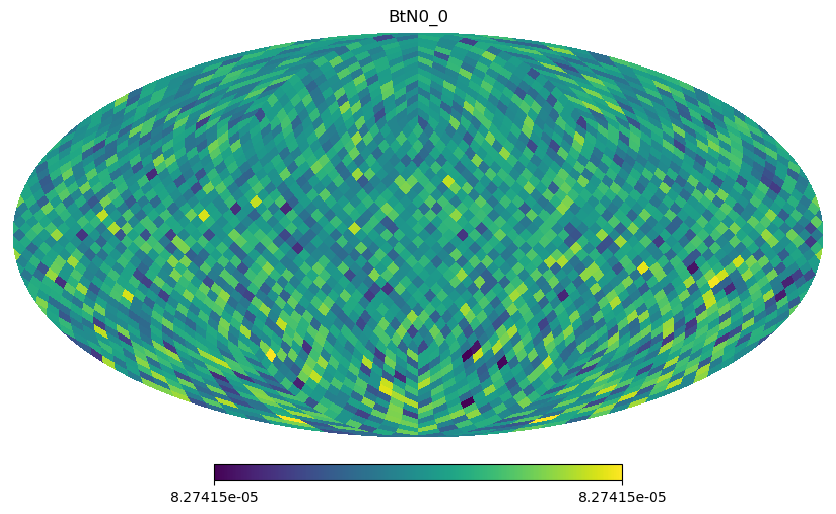

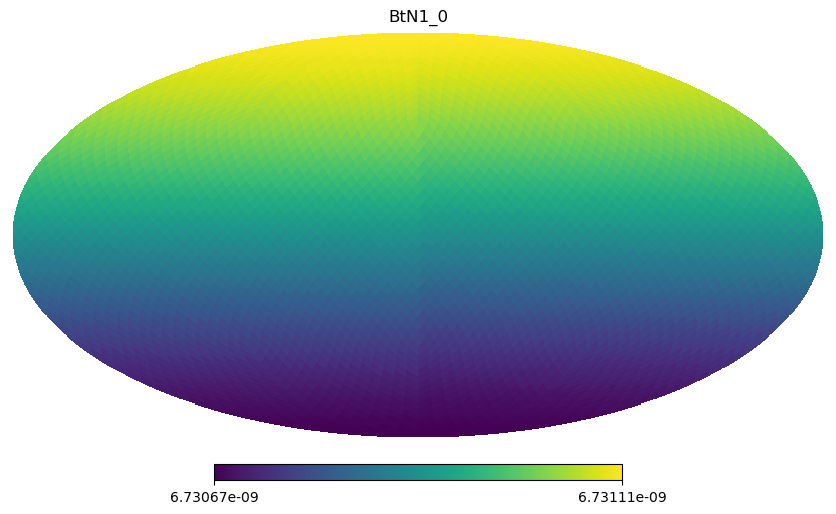

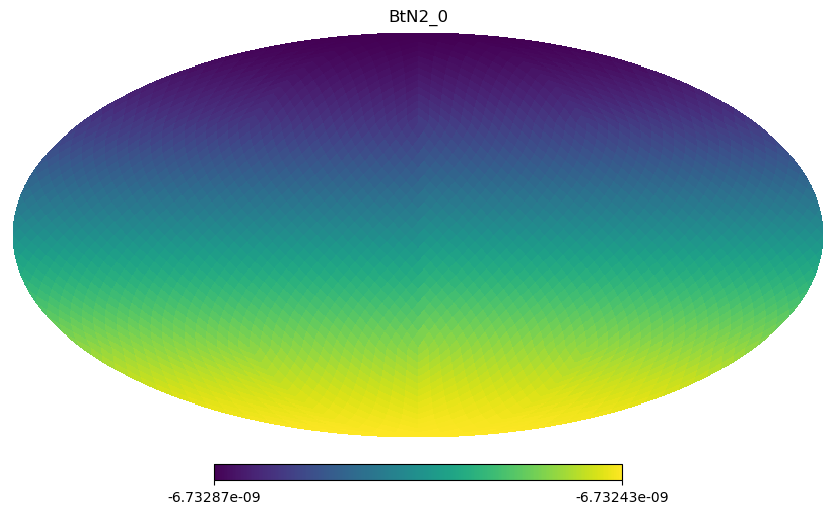

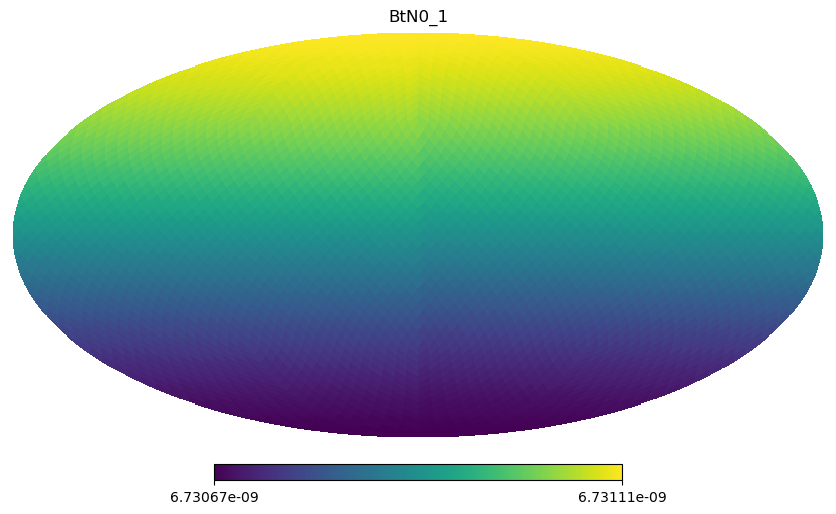

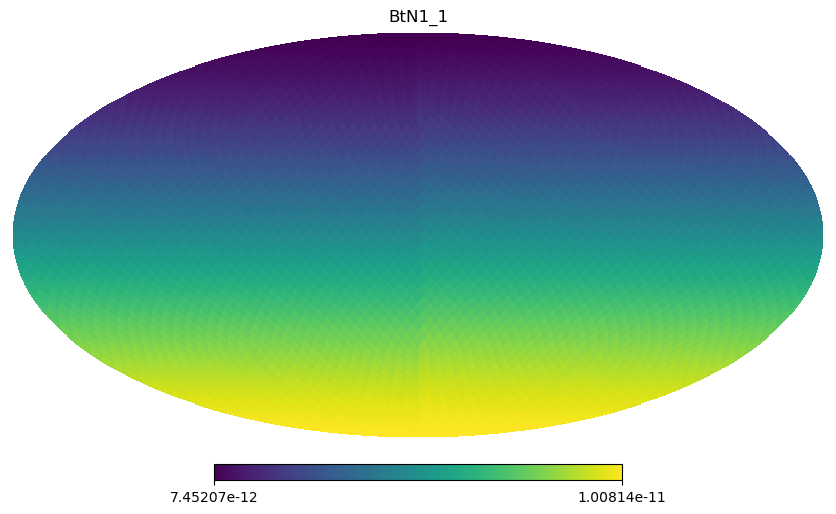

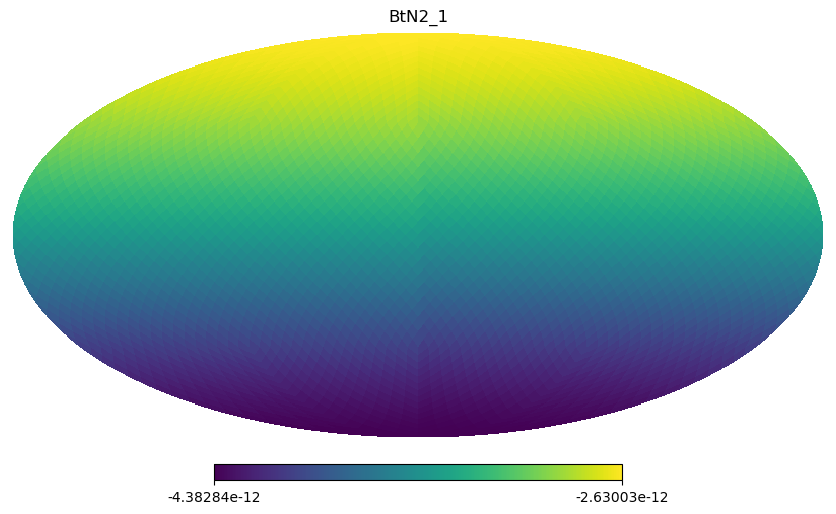

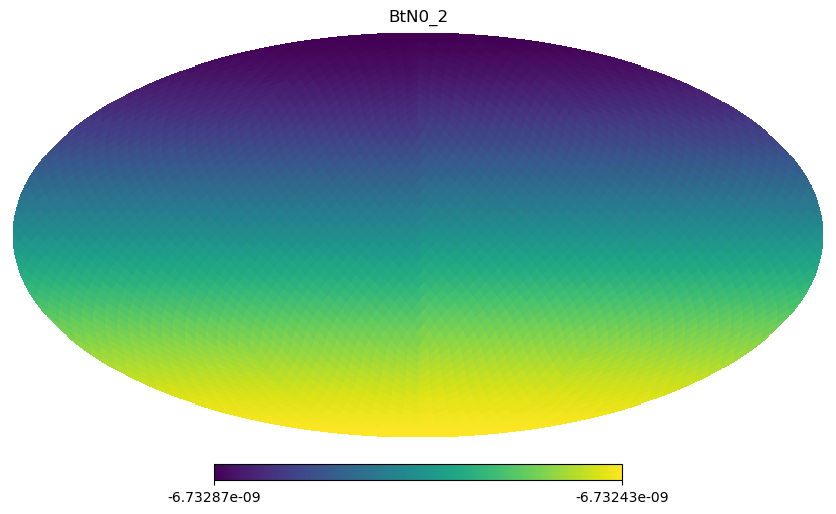

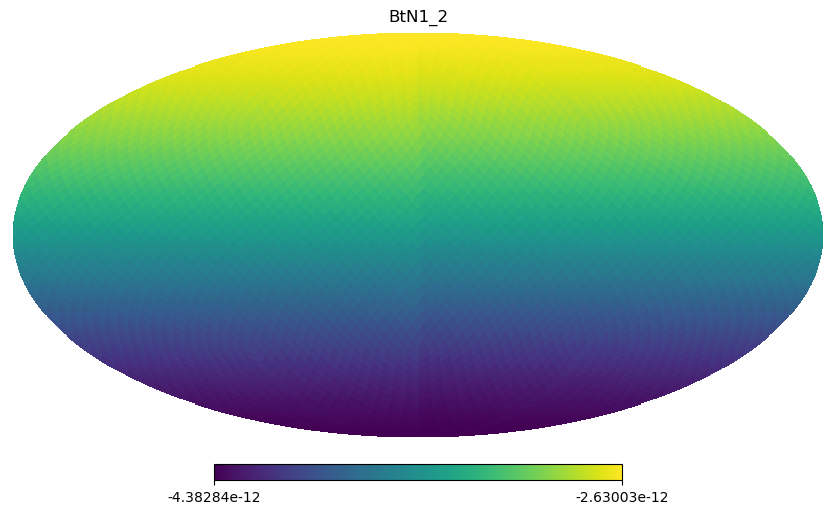

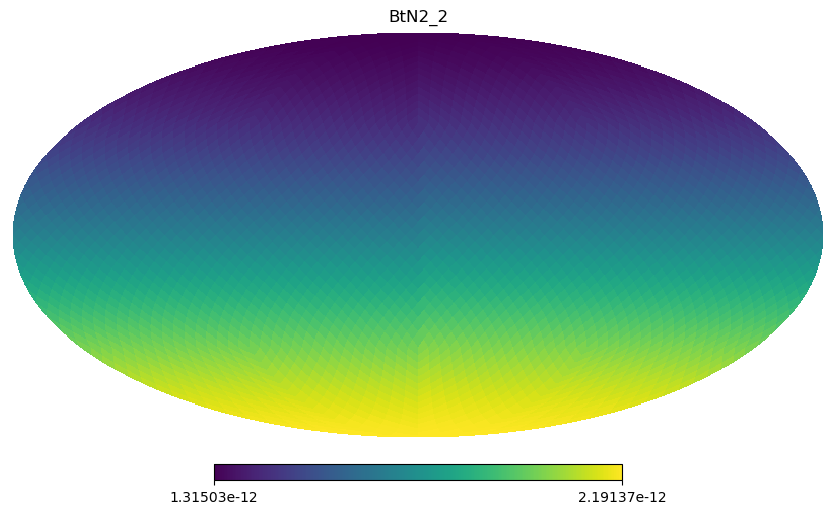

In [60]:
for comp in range(3):
    for freq in range(3):
        hp.mollview(inv_BtinvNB[comp,freq], title='BtN'+str(freq)+'_'+str(comp))

In [61]:
np.arange(0,12*8,12)

array([ 0, 12, 24, 36, 48, 60, 72, 84])

In [62]:
B.indexes_b

array([[    0, 12288],
       [ 3072, 15360],
       [ 6144, 18432],
       [ 9216, 21504]])

In [63]:
B.indexes_b.ravel(order='F')

array([    0,  3072,  6144,  9216, 12288, 15360, 18432, 21504])

In [64]:
B.update_params(init_params)

In [65]:
B.get_B(jax_use=True)[:,:,100000]

Array([[1.        , 1.        , 0.        ],
       [1.        , 0.33858815, 0.00979233],
       [1.        , 0.02963068, 0.05147511],
       [1.        , 0.00998213, 0.12913911],
       [1.        , 0.00328725, 0.44076761],
       [1.        , 0.        , 1.        ]], dtype=float64)

In [66]:
init_params

array([0.33858815, 0.33858815, 0.33858815, ..., 0.44076761, 0.44076761,
       0.44076761])